In [1]:
import os

import cfGPR
import vonkarman as vk
import treecorr

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c
import scipy.optimize as opt

In [2]:
p0 = np.array([
    200,
    1,
    .1,
    0,
    0
])

bounds = np.array([
    (1, 1000),
    (0.1, 10),
    (0.001, 1),
    (-10, 10),
    (-10, 10),
]).T

In [3]:
def getGrid(X1, X2):
    u1, u2 = X1[:, 0], X2[:, 0]
    v1, v2 = X1[:, 1], X2[:, 1]
    uu1, uu2 = np.meshgrid(u1, u2)
    vv1, vv2 = np.meshgrid(v1, v2)
    
    return uu1 - uu2, vv1 - vv2

In [4]:
def fit_vonKarman(X, variance, outerScale, diameter, wind_x, wind_y):
    
    theta = {
        'var': variance,
        'oS': outerScale,
        'd': diameter,
        'wind_x': wind_x,
        'wind_y': wind_y
    }
    params = ' '.join([f"{name:>8}: {x:<15.5f}" for name, x in theta.items()])
    with open(os.path.join(GP.outdir, "params.out"), mode='a+') as file:
        file.write(params + '\n')
    
    # Undo formatting of the grid.
    xx = X[0].reshape((int(np.sqrt(X[0].shape[0])), int(np.sqrt(X[0].shape[0]))))
    yy = X[1].reshape((int(np.sqrt(X[1].shape[0])), int(np.sqrt(X[1].shape[0]))))
    
    # Initialize an instance of the TubulentLayer class in order to
    # calculate the covariance function on the grid for the given parameters.
    ttt = vk.TurbulentLayer(
        variance=variance,
        outerScale=outerScale,
        diameter=diameter,
        wind=(wind_x, wind_y))
    
    # Caulculate covariance function, xi_plus, and return it.
    Cuv = ttt.getCuv(xx, yy)
    xiplus = Cuv[:, :, 0, 0] + Cuv[:, :, 1, 1]
    
    return xiplus.ravel(order='C')

In [5]:
"""Fit the first turbulent layer."""

# Specify maximum separation of points
maxSeparation = (30*u.arcmin).to(u.deg).value
nBins = 50

# Load data to be fit.
GP = cfGPR.CurlFreeGPR()
GP.load_fits('folio2')
GP.extract_data(465)
GP.sigma_clip()
GP.split_data(train_size=0.5)

# Calculate the 2pt correlation function of the entire dataset.
xiplus, counts = cfGPR.vcorr2d(GP.X[:, 0], GP.X[:, 1], GP.Y[:, 0], GP.Y[:, 1], rmax=maxSeparation, bins=nBins)
formatted_xiplus = xiplus.ravel(order='C')

# Generate Cuv on a grid
dx = maxSeparation / (nBins / 2) 
x = np.arange(-nBins / 2, nBins / 2) * dx
xx, yy = np.meshgrid(x, x)
X = np.vstack([xx.ravel(), yy.ravel()])

# Run the optimizer.
popt_first, pcov_first = opt.curve_fit(
    fit_vonKarman,
    X,
    formatted_xiplus,
    p0=p0,
    bounds=bounds)

# Initialize a von Karman model with the parameters from the optimizer.
ttt = vk.TurbulentLayer(
    variance=popt_first[0],
    outerScale=popt_first[1],
    diameter=popt_first[2],
    wind=(popt_first[3], popt_first[4]))

# Evaluate the covariance function on a grid for plotting.
Cuv_model_first = ttt.getCuv(xx, yy)
xiplus_model_first = Cuv_model_first[:, :, 0, 0] + Cuv_model_first[:, :, 1, 1]

/home/fortino/DESworkspace/vonkarman.py:183: RuntimeWarning: divide by zero encountered in log
  return  self.interpolator(np.log(r))


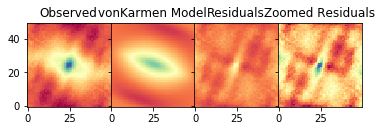

In [6]:
# Plot the 2pt correlation function of the observed data, the fitted model, the difference of the two,
# and a closeup of the difference. This helps evaluate the fit.
fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True)
fig.subplots_adjust(wspace=0)

axes[0].imshow(xiplus, origin='lower', cmap='Spectral', interpolation='nearest', vmin=xiplus.min(), vmax=xiplus.max())
axes[0].set_title("Observed")

axes[1].imshow(xiplus_model_first, origin='lower', cmap='Spectral', interpolation='nearest', vmin=xiplus.min(), vmax=xiplus.max())
axes[1].set_title("vonKarmen Model")

axes[2].imshow(xiplus - xiplus_model_first, origin='lower', cmap='Spectral', interpolation='nearest', vmin=xiplus.min(), vmax=xiplus.max())
axes[2].set_title("Residuals")

axes[3].imshow(xiplus - xiplus_model_first, origin='lower', cmap='Spectral', interpolation='nearest')
axes[3].set_title("Zoomed Residuals")

plt.show()

In [15]:
"""Fit the second turbulent layer"""
formatted_xiplus = (xiplus - xiplus_model_first).ravel(order='C')

# Specify maximum separation of points
maxSeparation = (10*u.arcmin).to(u.deg).value
nBins = 50

# Generate Cuv on a grid
dx = maxSeparation / (nBins / 2) 
x = np.arange(-nBins / 2, nBins / 2) * dx
xx, yy = np.meshgrid(x, x)
X = np.vstack([xx.ravel(), yy.ravel()])

# Run the optimizer.
popt_second, pcov_second = opt.curve_fit(
    fit_vonKarman,
    X,
    formatted_xiplus,
    p0=p0,
    bounds=bounds)

# Initialize a von Karman model with the parameters from the optimizer.
ttt = vk.TurbulentLayer(
    variance=popt_second[0],
    outerScale=popt_second[1],
    diameter=popt_second[2],
    wind=(popt_second[3], popt_second[4]))

# Evaluate the covariance function on a grid for plotting.
Cuv_model_second = ttt.getCuv(xx, yy)
xiplus_model_second = Cuv_model_second[:, :, 0, 0] + Cuv_model_second[:, :, 1, 1]

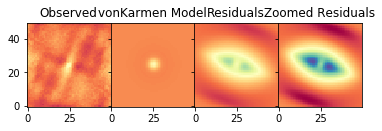

In [16]:
# Plot the 2pt correlation function of the observed data, the fitted model, the difference of the two,
# and a closeup of the difference. This helps evaluate the fit.
fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True)
fig.subplots_adjust(wspace=0)

axes[0].imshow(xiplus - xiplus_model_first, origin='lower', cmap='Spectral', interpolation='nearest', vmin=xiplus.min(), vmax=xiplus.max())
axes[0].set_title("Observed")

axes[1].imshow(xiplus_model_second, origin='lower', cmap='Spectral', interpolation='nearest', vmin=xiplus.min(), vmax=xiplus.max())
axes[1].set_title("vonKarmen Model")

axes[2].imshow(xiplus_model_first - xiplus_model_second, origin='lower', cmap='Spectral', interpolation='nearest', vmin=xiplus.min(), vmax=xiplus.max())
axes[2].set_title("Residuals")

axes[3].imshow(xiplus_model_first - xiplus_model_second, origin='lower', cmap='Spectral', interpolation='nearest')
axes[3].set_title("Zoomed Residuals")

plt.show()

Two layer method doesn't seem to work :(